# Note

## Update log

수정 사항 있으면 여기에 추가 기록 부탁합니닷

example : add plot function, 201217_1535, PKH


add nash activity when act<0 (but only for g_num=3 case) , 201221_0146, JJY

## Explanation

`_num` 접미사 : 실제 숫자, ex. total_pop_num, g_pop_num 등

`_num` 접미사 없는것 : population 대비 proportion, ex. g_pop

`g_` 접두사 : activity group에 대한 variable, ex. g_pi

# Code

## Packages

In [27]:
import argparse
import numpy as np
import matplotlib.pyplot as plt

## Parameters

In [14]:
import easydict
 
args = easydict.EasyDict({
    "total_pop_num": 100000,  #total_population number
    "epi_length": 1000,  # episode length
    "p": 0.1,  # infection probability
    "alpha": 1,  # system preventive level
    "beta": 10,  # frequency of contact
    "loss": 100,  # loss when infected
    "delay_period": 5,  # period of infected to confirmed
    "remove_period": 1,  # period of confirmed to removed
    "bounded": True,  # bounded rationality or not
    # Parameters related with groups
    "g_num": 3,  # number of activity groups
    "g_pi": [0.25, 0.5, 0.25],  # population proportion of activity group
    "g_default_act": [2, 1, 0.5],  # default activity level/preference for each group
    "g_init_infected_num": [10, 10, 10]  # initial infected number
})


## Model

In [15]:
class corona_world(object):
    def __init__(self, args):
        # Parameters
        self.total_pop_num = args.total_pop_num
        self.epi_length = args.epi_length
        self.p = args.p
        self.alpha = args.alpha
        self.beta = args.beta
        self.loss = args.loss
        self.delay_period = args.delay_period
        self.remove_period = args.remove_period
        self.bounded = args.bounded
        
        # Parameters related with groups
        self.g_num = args.g_num
        self.g_pi = args.g_pi
        self.g_default_act = args.g_default_act
        self.g_init_infected_num = args.g_init_infected_num
        
        # Variables changed by time 
        self.g_pop = np.zeros([self.epi_length + 1, self.g_num, 4])  # [time, group_index, type(S, I, C, R)]
        self.g_pop_change = np.zeros([self.epi_length + 1, self.g_num, 4]) # daily change, [time, group_index, type(S, I, C, R)]
        self.g_act = np.zeros([self.epi_length + 1, self.g_num])  # groups' activity level, [time, group_index]
        
    def initialize_world(self):
        for i in range(self.g_num):
            total_g_pop_num = self.total_pop_num * self.g_pi[i]
            infected_g_pop_num = self.g_init_infected_num[i]
            self.g_pop[0, i, 0] = (total_g_pop_num - infected_g_pop_num) / total_g_pop_num
            self.g_pop[0, i, 1] = infected_g_pop_num / total_g_pop_num
            self.g_act[0, i] = self.g_default_act[i]
            
    def calculate_activity(self, time):
        g_phi = np.zeros(self.g_num)
        
        if self.bounded:
            for i in range(self.g_num):
                g_phi[i] = self.alpha * self.g_pi[i] * self.p * self.beta * self.loss * self.g_pop[time-1, i, 2]
        else:
            for i in range(self.g_num):
                g_phi[i] = self.alpha * self.g_pi[i] * self.p * self.beta * self.loss * self.g_pop[time-1, i, 1]
        
        temp1 = np.dot(g_phi, 1 / (g_phi + 2))
        temp2 = np.dot(2 * np.array(self.g_default_act) * g_phi, 1 / (g_phi + 2))
        
        g_today_activity = (2 * np.array(self.g_default_act) - 1 / (1 + temp1) * temp2) / (g_phi + 2)
        
        ##### JJY #####
        if g_today_activity[2] < 0 :
            if g_today_activity[1] < 0 :
                g_today_activity = np.array([self.g_default_act[0]/(g_phi[0]+1),0,0])
            else:
                g_today_activity = np.array([2*(-g_phi[1]*self.g_default_act[1]+2*(g_phi[1]+1)*self.g_default_act[0])/(4*(g_phi[0]+1)*(g_phi[1]+1)-g_phi[0]*g_phi[1]),2*(-g_phi[0]*self.g_default_act[0]+2*(g_phi[0]+1)*self.g_default_act[1])/(4*(g_phi[1]+1)*(g_phi[0]+1)-g_phi[1]*g_phi[0]),0])
        ###############
        
        self.g_act[time] = g_today_activity
        
        return g_today_activity
    
    def step(self, time):
        g_today_activity = self.calculate_activity(time)  # 전날의 confirmed에 따른 당일의 activity
        param = self.alpha * self.p * self.beta
        
        # 당일 susceptible의 변화 / 당일의 activity에 따라 susceptible에서 infected로 가는 거 정의
        temp3 = 0
        for k in range(self.g_num):
            temp3 = temp3 + self.g_pi[k] * g_today_activity[k] * self.g_pop[time-1, k, 1]
        g_ds = - temp3 * param * g_today_activity * self.g_pop[time-1, :, 0]
        
        # 당일 infected의 변화 / -g_ds만큼 더해지고 confirm되는 infected가 빠짐
        g_today_confirmed = 1 / self.delay_period * self.g_pop[time-1, :, 1]         
        g_di = - g_ds - g_today_confirmed
        
        # 당일 confirmed의 변화 / delay_period전 infected가 더해지고 전날 confirmed가 빠짐
        g_today_removed = 1 / self.remove_period * self.g_pop[time-1, :, 2]
        g_dc = g_today_confirmed - g_today_removed
        
        # 당일 removed의 변화 / 전날 confirmed가 더해짐
        g_dr = g_today_removed
        
        # g_pop의 변화
        self.g_pop[time, :, 0] = self.g_pop[time-1, :, 0] + g_ds
        self.g_pop[time, :, 1] = self.g_pop[time-1, :, 1] + g_di
        self.g_pop[time, :, 2] = self.g_pop[time-1, :, 2] + g_dc
        self.g_pop[time, :, 3] = self.g_pop[time-1, :, 3] + g_dr
        
        self.g_pop_change[time, :, 0] = g_ds
        self.g_pop_change[time, :, 1] = g_di
        self.g_pop_change[time, :, 2] = g_dc
        self.g_pop_change[time, :, 3] = g_dr
    
    def run(self):
        self.initialize_world()
        
        for j in range(self.epi_length):
            time = j + 1
            self.step(time)
            

## Run

In [16]:
x = corona_world(args)
x.run()

In [17]:
np.set_printoptions(precision=8, linewidth=np.inf)

# Plot

In [18]:
def plot_g_pop(world, group, period=0):
    plt.figure(figsize=(10, 7))
    
    if period == 0:
        plt.plot(world.g_pop[:, group, 0], label='Susceptible')
        plt.plot(world.g_pop[:, group, 1], label='Infected')
        plt.plot(world.g_pop[:, group, 2], label='Confirmed')
        plt.plot(world.g_pop[:, group, 3], label='Removed')
    else:
        plt.plot(world.g_pop[:period, group, 0], label='Susceptible')
        plt.plot(world.g_pop[:period, group, 1], label='Infected')
        plt.plot(world.g_pop[:period, group, 2], label='Confirmed')
        plt.plot(world.g_pop[:period, group, 3], label='Removed')
    
#     plt.ylim([0, 1])
    plt.xlabel('Time', fontsize=20)
    plt.ylabel('Proportion', fontsize=20)
    plt.legend(loc='lower right')
    plt.grid()

def plot_g_act(world, period=0):
    plt.figure(figsize=(10, 7))
    
    if period == 0:
        for i in range(world.g_num):
            plt.plot(world.g_act[:, i], label='Activity level for group '+str(i))
    else:
        for i in range(world.g_num):
            plt.plot(world.g_act[:period, i], label='Activity level for group '+str(i))
    
    plt.ylim([-1, 2])
    plt.xlabel('Time', fontsize=20)
    plt.ylabel('Activity level', fontsize=20)
    plt.legend(loc='lower right')
    plt.grid()

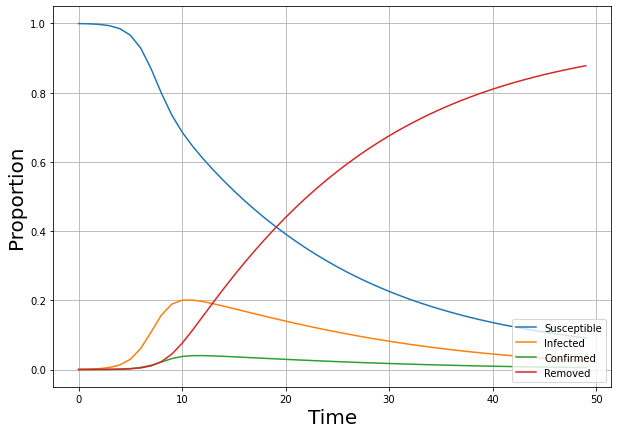

In [19]:
plot_g_pop(x, 0, 50)

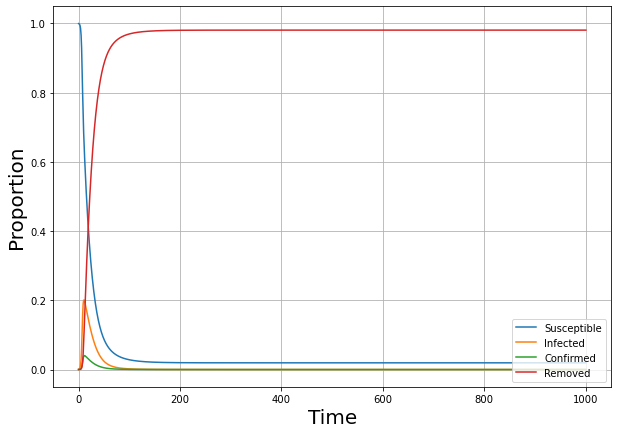

In [20]:
plot_g_pop(x, 0)

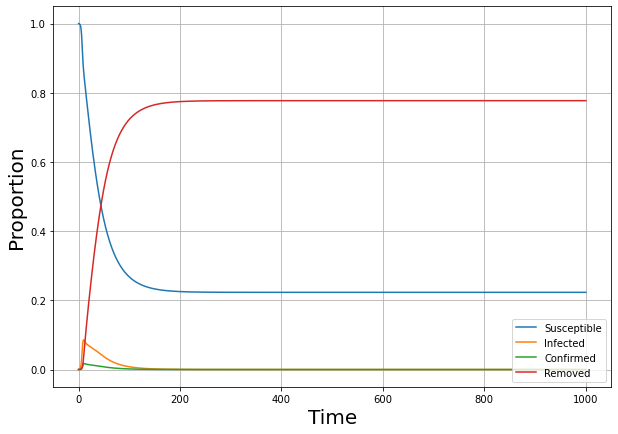

In [21]:
plot_g_pop(x, 1)

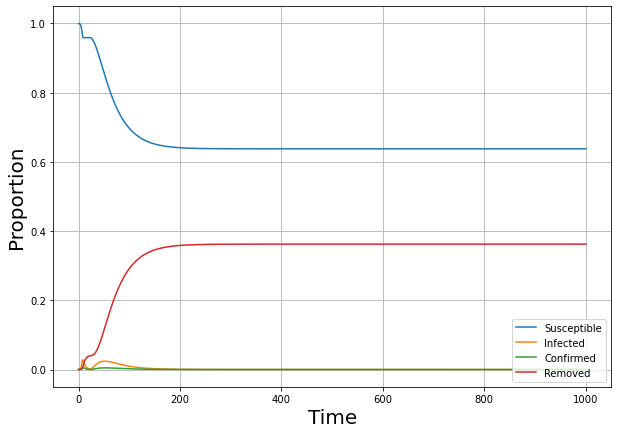

In [22]:
plot_g_pop(x, 2)

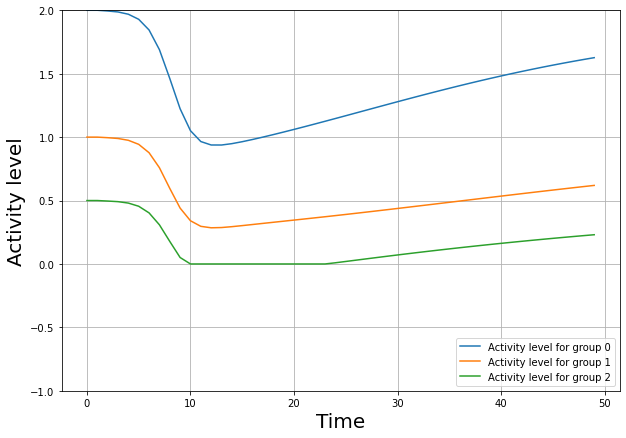

In [23]:
plot_g_act(x, 50)

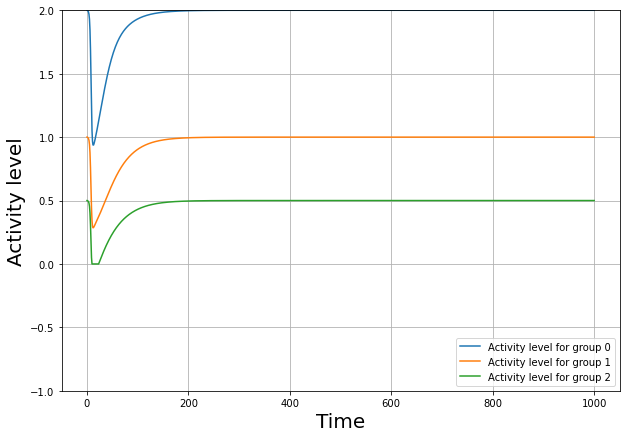

In [24]:
plot_g_act(x)

In [25]:
x.g_pop[0:30]

array([[[9.99600000e-01, 4.00000000e-04, 0.00000000e+00, 0.00000000e+00],
        [9.99800000e-01, 2.00000000e-04, 0.00000000e+00, 0.00000000e+00],
        [9.99600000e-01, 4.00000000e-04, 0.00000000e+00, 0.00000000e+00]],

       [[9.98900280e-01, 1.01972000e-03, 8.00000000e-05, 0.00000000e+00],
        [9.99450070e-01, 5.09930000e-04, 4.00000000e-05, 0.00000000e+00],
        [9.99425070e-01, 4.94930000e-04, 8.00000000e-05, 0.00000000e+00]],

       [[9.97259283e-01, 2.45677271e-03, 2.03944000e-04, 8.00000000e-05],
        [9.98630553e-01, 1.22746052e-03, 1.01986000e-04, 4.00000000e-05],
        [9.99016755e-01, 8.04258608e-04, 9.89860000e-05, 8.00000000e-05]],

       [[9.93442997e-01, 5.78170491e-03, 4.91354543e-04, 2.83944000e-04],
        [9.96727648e-01, 2.88487341e-03, 2.45492104e-04, 1.41986000e-04],
        [9.98071562e-01, 1.58860007e-03, 1.60851722e-04, 1.78986000e-04]],

       [[9.84753037e-01, 1.33153232e-02, 1.15634098e-03, 7.75298543e-04],
        [9.92410186e-01, 6.625

In [26]:
x.g_act[0:30]

array([[2.        , 1.        , 0.5       ],
       [2.        , 1.        , 0.5       ],
       [1.99451942, 0.99551843, 0.49601793],
       [1.98674031, 0.98928278, 0.49119734],
       [1.96886591, 0.97497483, 0.47999345],
       [1.92883001, 0.94310612, 0.45490318],
       [1.84470906, 0.87706204, 0.40269412],
       [1.68967317, 0.75896772, 0.30878328],
       [1.46269531, 0.59607442, 0.17792069],
       [1.22361737, 0.44052939, 0.05085938],
       [1.05059838, 0.34060399, 0.        ],
       [0.96516091, 0.29667414, 0.        ],
       [0.93797503, 0.28512688, 0.        ],
       [0.93774416, 0.28712984, 0.        ],
       [0.94851154, 0.29397267, 0.        ],
       [0.96387473, 0.30233022, 0.        ],
       [0.9814231 , 0.31105893, 0.        ],
       [1.0002111 , 0.31981253, 0.        ],
       [1.01982193, 0.32851885, 0.        ],
       [1.0400399 , 0.33719262, 0.        ],
       [1.0607339 , 0.34587071, 0.        ],
       [1.08181288, 0.35459047, 0.        ],
       [1.